In [1]:
# Visualization
from PIL import Image
from torchvision import transforms
import tifffile
import matplotlib.pyplot as plt

from time import time
import numpy as np

# Pre trained VGG 19 
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image Style Transfer Using Convolutional Neural Networks

Leon A. Gatys, Alexander S. Ecker & Matthias Bethge. (2016). Image Style Transfer Using Convolutional Neural Networks. [Downloadable here](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)

In [2]:
# Set default parameters for pyplot
plt.rcParams['figure.figsize'] = [17.0, 8.0]

# Notebook constants
TEXTURE_IMAGE_PATH = "Data/picasso.jpg"
CONTENT_IMAGE_PATH = "Data/tomhardy.jpg"
CNOISE_IMAGE_PATH = "Data/content_noise.jpg"
TNOISE_IMAGE_PATH = "Data/texture_noise.jpg"


# Small custom method to show images neatly
def custom_imshow(image, title = '', axis = 'off'):
    plt.imshow(image)
    plt.title(title)
    plt.axis(axis)

Explain goal : transfer the style from texture_image onto content_image. 

### 0.1 The data


We will use a picture of Tom Hardy as the content image and a painting of Kandinsky as the texture image/

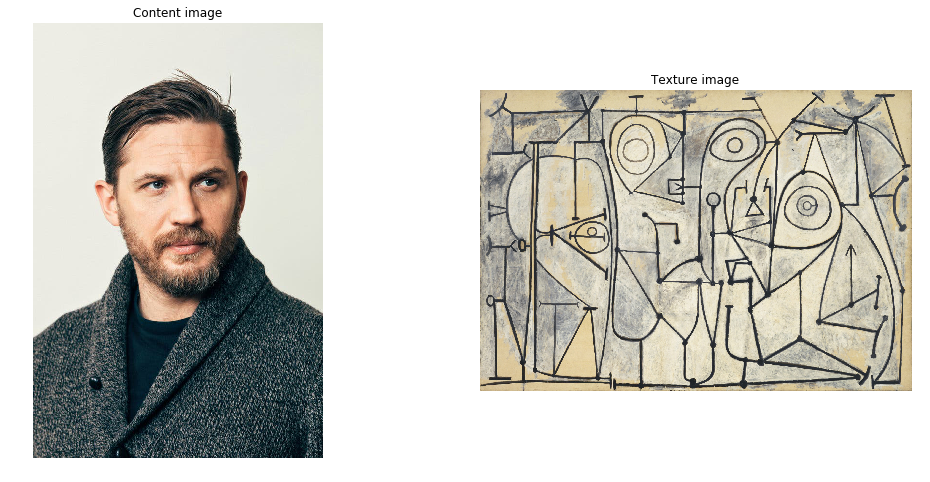

In [3]:
texture_image = Image.open(TEXTURE_IMAGE_PATH)
texture_h, texture_w, _ = np.asarray(texture_image).shape

content_image = Image.open(CONTENT_IMAGE_PATH)
content_h, content_w, _ = np.asarray(content_image).shape

plt.subplot(1, 2, 1)
custom_imshow(content_image, title = 'Content image')
plt.subplot(1, 2, 2)
custom_imshow(texture_image, title = 'Texture image')
plt.show()

### 0.2 The network

Download pre trained VGG 19 model which will serve to extract features from the images. We remove its classification part and use the remaining network as a feature extractor on our image.

In [4]:
# Get Model
vgg19 = models.vgg19(pretrained = True)
#vgg19.eval()

# Remove avg pool and classification part
vgg19_features = vgg19.features

In [5]:
index = 0
conv_layer_indices = []

for module in vgg19_features:
    if isinstance(module, nn.modules.conv.Conv2d):
        conv_layer_indices.append(index)
    index+=1
    
print("The model has conv layers at following indices :\n", conv_layer_indices)

The model has conv layers at following indices :
 [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]


### 0.3 Helper functions

Some helper functions to manipulate tensors and visualize them. We also create functions to generate white noise images which are used to illustrate the content representation and style representation sections.

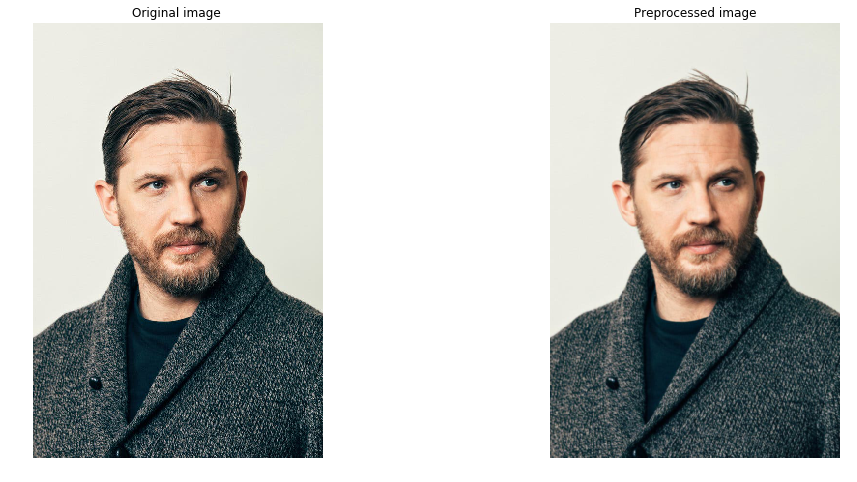

In [6]:
def create_and_save_white_noise_image(w, h, path):
    noise = np.zeros((h, w, 3), 'uint8')
    random_matrix = np.random.randint(0, 255, size = (h, w)).astype(np.uint8)
    noise[...,0] = noise[...,1] = noise[...,2] = random_matrix
    Image.fromarray(noise).save(path)
    
create_and_save_white_noise_image(content_w, content_h, CNOISE_IMAGE_PATH)
create_and_save_white_noise_image(texture_w, texture_h, TNOISE_IMAGE_PATH)

def pil_image_to_torch_tensor(image):
    preprocess = transforms.Compose([transforms.Resize(300),
                         transforms.ToTensor()])
                         #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    return preprocess(image).unsqueeze(0)

def display_tensor_image(tensor, title = ''):
    custom_imshow(tensor.squeeze(0).permute(1, 2, 0).detach().numpy(), title)
    
plt.subplot(1, 2, 1)
custom_imshow(content_image, title = 'Original image ')
plt.subplot(1, 2, 2)
display_tensor_image(pil_image_to_torch_tensor(content_image), title = 'Preprocessed image')
plt.show()

## 1. Content reconstruction

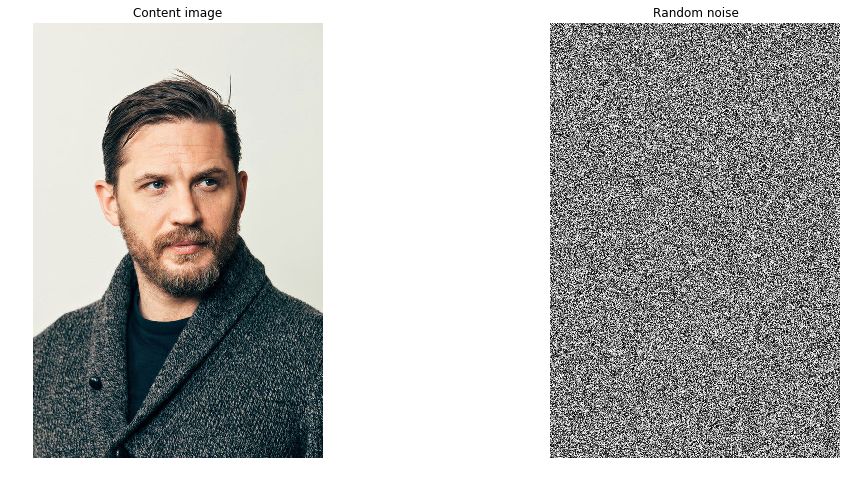

In [7]:
noise_image = Image.open(CNOISE_IMAGE_PATH)

plt.subplot(1, 2, 1)
custom_imshow(content_image, title = 'Content image')
plt.subplot(1, 2, 2)
custom_imshow(noise_image, title = 'Random noise')
plt.show()

Given a **content image $p$** and a generated **white noise image $x$**, we examine the feature maps generated by the different convolutional layers of the pre-trained network VGG19. For the layer $l$, we denote $N_l$ the number of feature maps and $M_l$ their size (height $*$ weigth of the feature map). Thus, the responses of the layer $l$ for the image $P$ can be stored in a $N_l * M_l$ matrix $P^l$ where $P^l_{ij}$ is the activation of the $i^{th}$ filter at position $j$ in layer $l$. This matrix is referred to as the feature representation of the input image at layer $l$.

Given $P^l$ and $F^l$, the feature representations of respectively $p$ and $x$, the content loss is defined as $\frac{1}{2}\sum_{i,j}(F^l_{ij} - P^l_{ij})^2$.

In [13]:
class ContentLoss(nn.Module):
    
    def __init__(self, target_image_features):
        super(ContentLoss, self).__init__()
        self.target_image_features = target_image_features.detach()
        
    def forward(self, input_image_features):
        return F.mse_loss(input_image_features, self.target_image_features)


[]

In [8]:
# --------------------------------------------------------------------------

    

# --------------------------------------------------------------------------
class ContentRepresentation(nn.Module):
    
    def __init__(self, feature_network, target_image):
        super(ContentRepresentation, self).__init__()
        self.feature_network = feature_network
        self.target_image = target_image
        self.target_image_features = feature_network(target_image)
        
    def forward(self, input_image):
        content_loss = ContentLoss(self.target_image_features)
        return content_loss(self.feature_network(input_image))

 We are seeking to minimize this quantity to gradient descent, by updating the values of the initial image $x$ "until it generates the same response in a certain layer of the
Convolutional Neural Network as the original image $p$."

In [9]:
target_image = pil_image_to_torch_tensor(content_image)
cr_model = ContentRepresentation(vgg19_features[:3], target_image)
optimizer = optim.SGD(cr_model.parameters(), lr = 0.01)

In [10]:
input_image = pil_image_to_torch_tensor(noise_image)
input_image.requires_grad_(True)

for i in np.arange(100):
    
    
    print(input_image.grad, input_image.requires_grad)
    output = cr_model(input_image)
    output.backward()
    print(input_image.grad, input_image.requires_grad)
    
    input_image=input_image - (0.01*input_image.grad)
    print(input_image)
    
    loss = output.item()
    print(input_image.grad, input_image.requires_grad)
    if (i % 20 == 0):
            print(str(i) + " : " + str(loss))

None True
tensor([[[[ 3.7392e-06,  1.0516e-05,  1.5988e-05,  ...,  1.1171e-05,
            1.2025e-05,  1.6481e-05],
          [-1.2770e-05, -9.3504e-06,  2.0834e-05,  ...,  2.4111e-05,
            3.3036e-06, -1.1022e-05],
          [-5.6965e-06, -3.6909e-05, -3.8057e-05,  ..., -8.9633e-06,
           -4.4968e-05, -3.7726e-05],
          ...,
          [ 2.0857e-05,  2.9451e-05,  2.0561e-05,  ...,  2.8552e-05,
            2.8617e-05, -1.4444e-05],
          [ 2.9940e-06,  1.7862e-05,  8.7201e-05,  ...,  7.9733e-07,
            5.5788e-05,  1.1830e-05],
          [-2.6775e-05, -3.3201e-05,  4.2708e-05,  ..., -4.5760e-05,
            7.4099e-06,  1.3401e-05]],

         [[ 3.8011e-07,  1.5923e-05,  2.5887e-05,  ...,  2.4044e-05,
            2.3250e-05,  2.2612e-05],
          [-2.6830e-05, -2.0252e-05,  2.7098e-05,  ...,  4.1022e-05,
            5.5978e-06, -1.9486e-05],
          [-1.2392e-05, -6.2848e-05, -6.3565e-05,  ..., -1.6505e-05,
           -7.6647e-05, -6.8202e-05],
          

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [55]:
print(output)

tensor(0.3568, grad_fn=<MseLossBackward>)


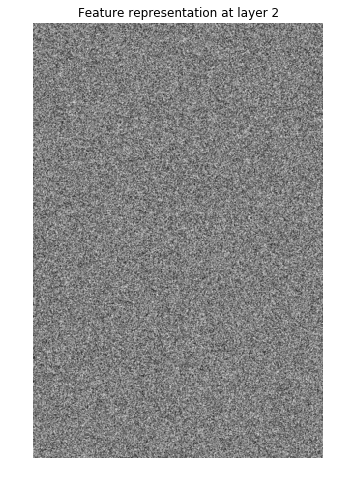

In [54]:
display_tensor_image(input_image, title = 'Feature representation at layer ' + str(conv_layer_index))

In [16]:
def get_content_representation(full_network, 
                               last_conv_index, 
                               content_image, 
                               noise_image, 
                               learning_rate = 0.001, 
                               n_iter = 100):
    
    network = full_network[:last_conv_index + 1]
    
    p = pil_image_to_torch_tensor(content_image)
    x = pil_image_to_torch_tensor(noise_image)
    
    losses = []
    t = time()
    
    for iteration in np.arange(n_iter):
        
        x_old = x.detach()
        x_old.requires_grad_(True)

        p_fmaps = network(p)
        x_fmaps = network(x_old)
        
        loss = content_loss(x_fmaps, p_fmaps)
        losses.append(loss.item())
        
        loss.backward()

        x = x_old - learning_rate * x_old.grad
        
        if (iteration % 10 == 0):
            print(str(iteration) + " " + str(loss.item()), end = ', ')
            
    print("Done in %.2f seconds" %(time() - t))
    
    return x, losses

Now for each convolutional layer we can apply gradient descent to update $x$ untill it matches the feature representation of the content image.

In [17]:
print(conv_layer_indices)

[0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]


In [18]:
# Define parameters of run
conv_layer_index = 2
learning_rate = 0.01
n_iter = 150

# Get optimization result
feature_representation, losses = get_content_representation(vgg19_features, 
                                                             conv_layer_index, 
                                                            content_image,
                                                            noise_image, 
                                                            learning_rate,
                                                            n_iter)
 
print("Final loss value : ", losses[-1])

# Save result as tif to avoid loss (since the array is of dtype float)
array_to_save = feature_representation.squeeze(0).permute(1, 2, 0).detach().numpy()
tifffile.imsave("Data/CR_FeatureRepresentationLayer" + str(conv_layer_index) + ".tiff", array_to_save)

# Visualize result (manual error check)
plt.subplot(1, 3, 1)
custom_imshow(content_image, title = 'Input content image')
plt.subplot(1, 3, 2)
display_tensor_image(feature_representation, title = 'Feature representation at layer ' + str(conv_layer_index))
plt.subplot(1, 3, 3)
plt.plot(losses)
plt.title('Content loss evolution')
plt.show()

0 7322723.0, 10 1.1322345637543097e+32, 

KeyboardInterrupt: 